In [1]:
# initial notebook prior to acquire.py and explore.py being created.  Just exploring and familiarizing myself
# with the data

import pandas as pd
import numpy as np
import env
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import wrangle
import warnings
warnings.filterwarnings("ignore")


In [2]:
url = env.get_url(env.user, env.host, env.password, 'zillow')

In [76]:
df = pd.read_sql('''
                SELECT parcelid, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet as sqft, fips as county, fireplacecnt,
                       fullbathcnt, garagecarcnt, garagetotalsqft, hashottuborspa, lotsizesquarefeet, poolcnt, rawcensustractandblock,
                       roomcnt, unitcnt, yearbuilt, structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt,
                       taxdelinquencyflag, taxdelinquencyyear, logerror, transactiondate, propertylandusedesc
                FROM properties_2017
                JOIN predictions_2017
                USING (parcelid)
                JOIN propertylandusetype
                USING (propertylandusetypeid)
                HAVING propertylandusedesc = 'Single Family Residential'
                    ''', url)

In [4]:
df.shape

(52442, 24)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49725 entries, 0 to 52440
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   parcelid                    49725 non-null  int64         
 1   bathroomcnt                 49725 non-null  float64       
 2   bedroomcnt                  49725 non-null  float64       
 3   sqft                        49725 non-null  float64       
 4   county                      49725 non-null  object        
 5   fireplacecnt                49725 non-null  float64       
 6   fullbathcnt                 49725 non-null  float64       
 7   garagecarcnt                49725 non-null  float64       
 8   garagetotalsqft             49725 non-null  float64       
 9   hashottuborspa              49725 non-null  float64       
 10  lotsizesquarefeet           49725 non-null  float64       
 11  poolcnt                     49725 non-null  float64   

In [79]:
df[df.parcelid == 13083743]

,parcelid,bathroomcnt,bedroomcnt,sqft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,propertylandusedesc
10141,13083743,2.0,3.0,1050.0,6037.0,NaN,2.0,NaN,NaN,NaN,...,77118.0,259334.0,182216.0,3345.78,None,NaN,6.037408e+13,0.138146,2017-03-07,Single Family Residential
10142,13083743,2.0,3.0,1050.0,6037.0,NaN,2.0,NaN,NaN,NaN,...,77118.0,259334.0,182216.0,3345.78,None,NaN,6.037408e+13,-0.197755,2017-05-25,Single Family Residential
52441,13083743,2.0,3.0,1050.0,6037.0,NaN,2.0,NaN,NaN,NaN,...,77118.0,259334.0,182216.0,3345.78,None,NaN,6.037408e+13,-0.197755,2018-05-25,Single Family Residential


In [80]:
df.transactiondate = pd.to_datetime(df.transactiondate, infer_datetime_format=True) 

In [81]:
# remove one transaction where date is in 2018
df = df[df.transactiondate < '2018-01-01']

In [82]:
# look at fips codes - 3 values corresponding to 3 counties in california
df.county.value_counts()

6037.0    33910
6059.0    14136
6111.0     4395
Name: county, dtype: int64

In [83]:
# convert fips to county
df.county = df.county.map({6037 : 'Los Angelos', 6059 : 'Orange', 6111 : 'Ventura'})

In [84]:
# convert poolcnt nulls to 0
df.poolcnt = df.poolcnt.fillna(0)

In [85]:
# convert fireplace count nulls to 0
df.fireplacecnt = df.fireplacecnt.fillna(0)

In [86]:
# garage null values to 0
df.garagecarcnt = df.garagecarcnt.fillna(0)
df.garagetotalsqft = df.garagetotalsqft.fillna(0)

In [87]:
# hottub/spa nulls to 0
df.hashottuborspa = df.hashottuborspa.fillna(0)

In [88]:
# has pool nulls to 0
df.poolcnt = df.poolcnt.fillna(0)

In [89]:
# drop rows where unit count is 2 or 3
df = df[(df.unitcnt != 2) & (df.unitcnt != 3)]

# then drop column
df.drop(columns='unitcnt', inplace=True)

In [94]:
# drop rows where tax delinquency exists
df = df[df.taxdelinquencyflag != 'Y']

# then drop columns
df.drop(columns=['taxdelinquencyflag', 'taxdelinquencyyear'], inplace=True)

In [96]:
df = df.dropna()

In [97]:
df.shape

(49725, 23)

In [102]:
df.taxamount.value_counts()

345.72      4
3415.94     3
5220.54     3
3509.14     3
3406.33     3
           ..
6053.94     1
20267.63    1
14552.69    1
5701.41     1
6317.15     1
Name: taxamount, Length: 48272, dtype: int64

In [5]:
import acquire
import prepare

In [4]:
df = acquire.get_zillow()

In [3]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,sqft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate,propertylandusedesc
0,14297519,3.5,4.0,3100.0,6059.0,NaN,3.0,2.0,633.0,NaN,...,NaN,1998.0,485713.0,1023282.0,537569.0,None,NaN,0.025595,2017-01-01,Single Family Residential
1,17052889,1.0,2.0,1465.0,6111.0,1.0,1.0,1.0,0.0,NaN,...,NaN,1967.0,88000.0,464000.0,376000.0,None,NaN,0.055619,2017-01-01,Single Family Residential
2,14186244,2.0,3.0,1243.0,6059.0,NaN,2.0,2.0,440.0,NaN,...,NaN,1962.0,85289.0,564778.0,479489.0,None,NaN,0.005383,2017-01-01,Single Family Residential
3,12177905,3.0,4.0,2376.0,6037.0,NaN,3.0,NaN,NaN,NaN,...,1.0,1970.0,108918.0,145143.0,36225.0,None,NaN,-0.103410,2017-01-01,Single Family Residential
4,12095076,3.0,4.0,2962.0,6037.0,NaN,3.0,NaN,NaN,NaN,...,1.0,1950.0,276684.0,773303.0,496619.0,None,NaN,-0.001011,2017-01-01,Single Family Residential


In [4]:
df = prepare.prep_zillow(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49779 entries, 0 to 52440
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   parcelid                    49779 non-null  int64         
 1   bathroomcnt                 49779 non-null  float64       
 2   bedroomcnt                  49779 non-null  float64       
 3   sqft                        49779 non-null  float64       
 4   county                      49779 non-null  float64       
 5   fireplacecnt                49779 non-null  float64       
 6   fullbathcnt                 49779 non-null  float64       
 7   garagecarcnt                49779 non-null  float64       
 8   garagetotalsqft             49779 non-null  float64       
 9   hashottuborspa              49779 non-null  float64       
 10  lotsizesquarefeet           49779 non-null  float64       
 11  poolcnt                     49779 non-null  float64   

# acquire and prepare now combined in wrangle.py

In [2]:
import wrangle
df = wrangle.get_zillow()
df = wrangle.prep_zillow(df)
col_list = ['bathroomcnt', 'bedroomcnt', 'sqft', 'lotsizesquarefeet', 'yearbuilt', 'tax_value']
df = wrangle.remove_outliers(df, 1.5, col_list)

In [3]:
df.shape

(43698, 13)

In [4]:
df.head().T

,0,1,2,3,5
parcelid,14297519,17052889,14186244,12177905,12069064
bathroomcnt,3.5,1.0,2.0,3.0,1.0
bedroomcnt,4.0,2.0,3.0,4.0,2.0
sqft,3100.0,1465.0,1243.0,2376.0,738.0
county,Orange,Ventura,Orange,Los Angelos,Los Angelos
fireplacecnt,0.0,1.0,0.0,0.0,0.0
garagecarcnt,2.0,1.0,2.0,0.0,0.0
hashottuborspa,0.0,0.0,0.0,0.0,0.0
lotsizesquarefeet,4506.0,12647.0,8432.0,13038.0,4214.0
poolcnt,0.0,0.0,1.0,1.0,0.0


In [5]:
train, validate, test = wrangle.my_split(df)

def plot_variable_pairs(df):
    cols = ['bedroomcnt', 'bathroomcnt',  'yearbuilt',  'county', 'fireplacecnt', 'hashottuborspa', 'poolcnt',
            'sqft', 'lotsizesquarefeet', 'taxvalue']
    
    
    # make correlation plot
    train_corr = train[cols].corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(train_corr, cmap='Purples', annot = True, mask= np.triu(train_corr), linewidth=.5)
    plt.show()

In [6]:
import explore
explore.initial_charts(train)

NameError: name 'train' is not defined

# begin explore

In [7]:
import explore

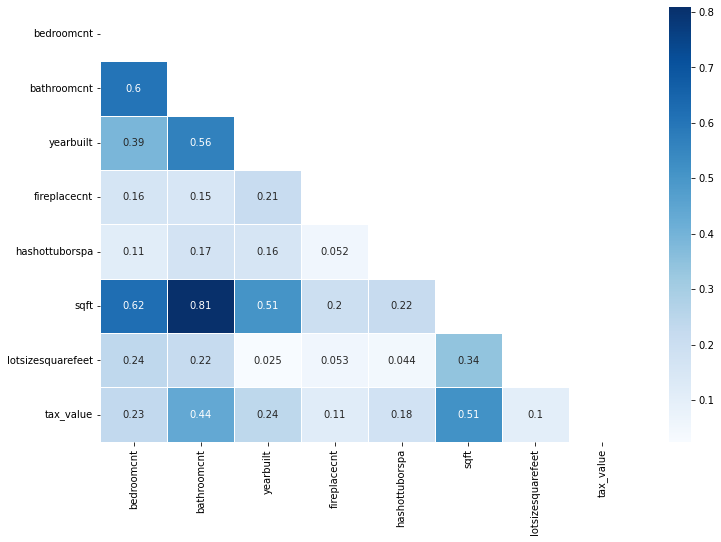

In [22]:
#explore.plot_variable_pairs(train)
cols = ['bedroomcnt', 'bathroomcnt',  'yearbuilt',  'county', 'fireplacecnt', 'hashottuborspa',
            'sqft', 'lotsizesquarefeet', 'tax_value']
    
    
# make correlation plot
df_corr = train[cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, cmap='Blues', annot = True, mask= np.triu(df_corr), linewidth=.5)
plt.show()

### sqft is highly correlated with br and bathroom count - may not want to use them all for modeling

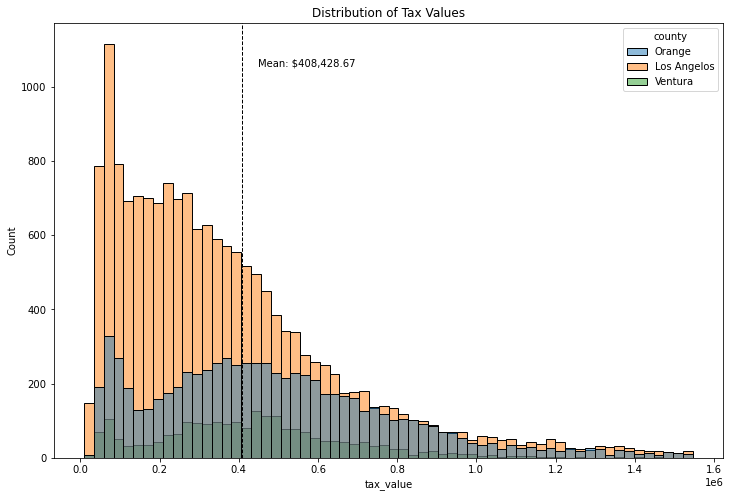

In [23]:
# Plot Distribution of target variable
plt.figure(figsize=(12,8))
plt.title('Distribution of Tax Values')
sns.histplot(data=train, x='tax_value', hue='county')
plt.axvline(train.tax_value.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(train.tax_value.mean()*1.1, max_ylim*0.9, 'Mean: ${:,.2f}'.format(train.tax_value.mean()))
plt.show()

# data is positively (right) skewed.  Will want to transform prior to modeling


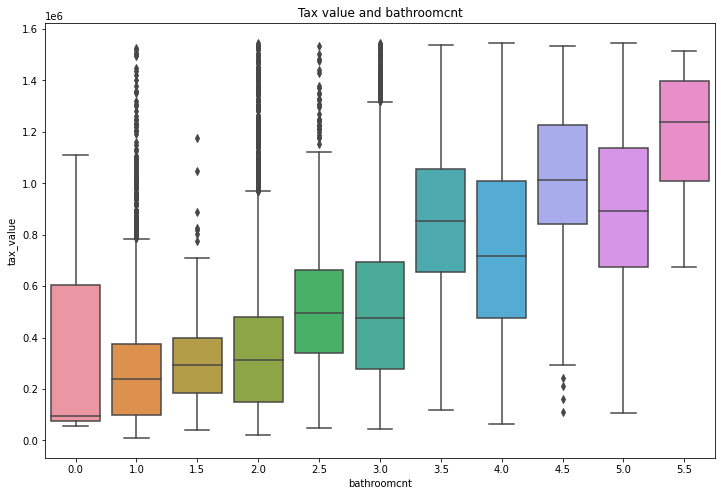

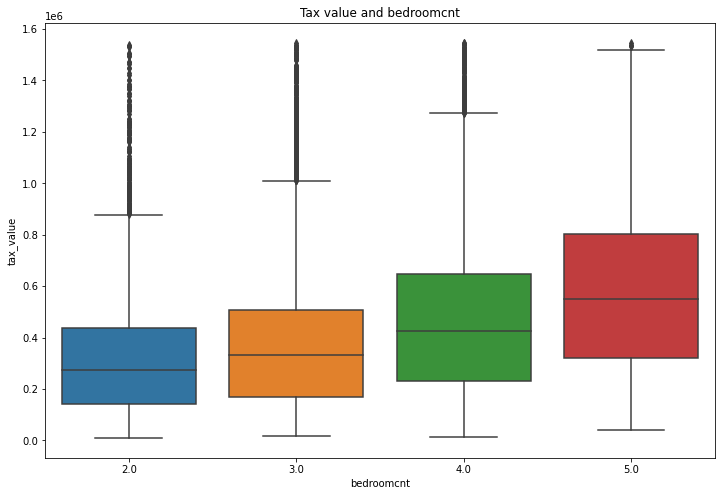

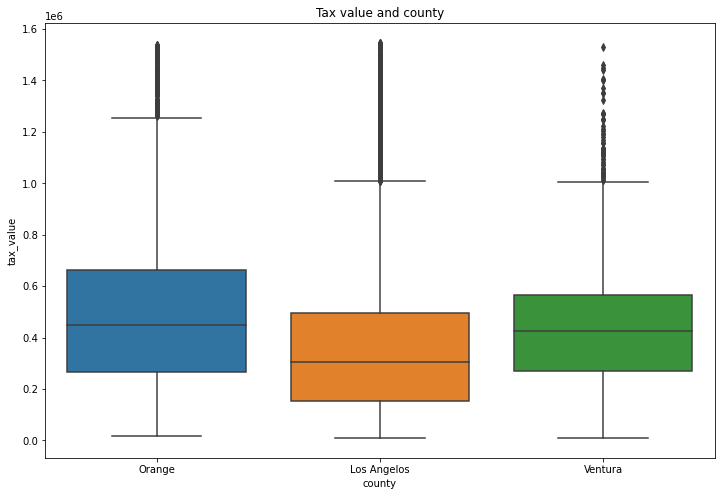

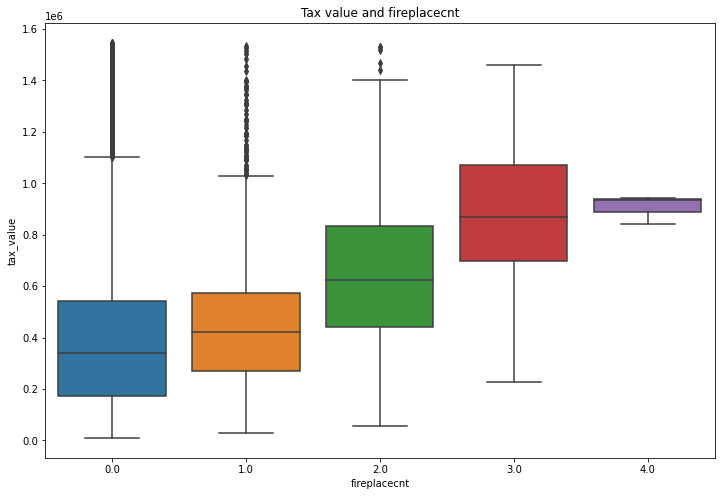

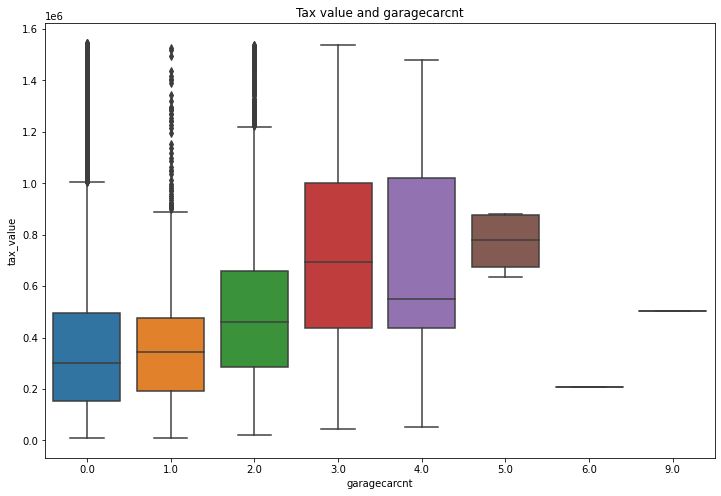

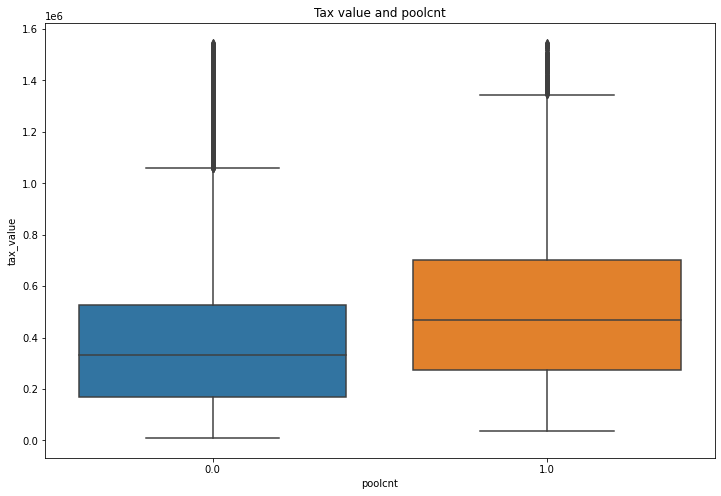

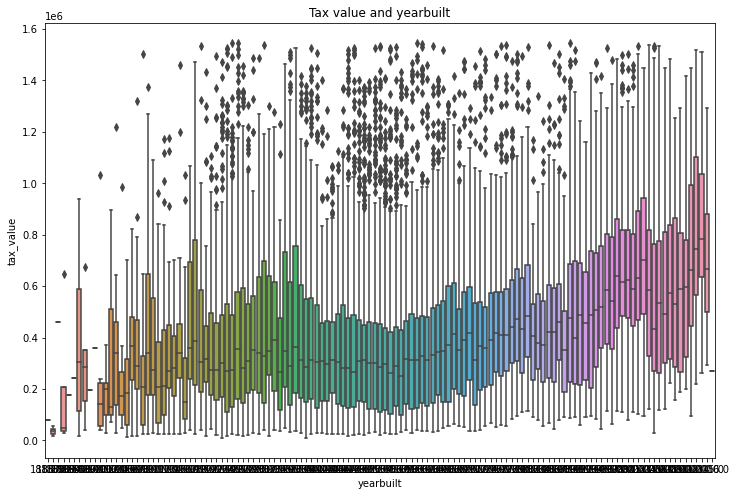

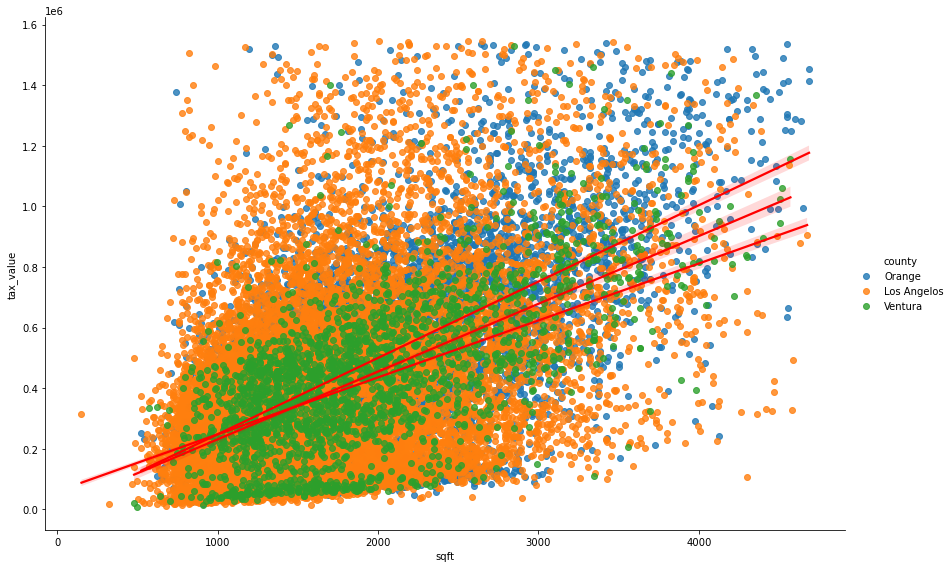

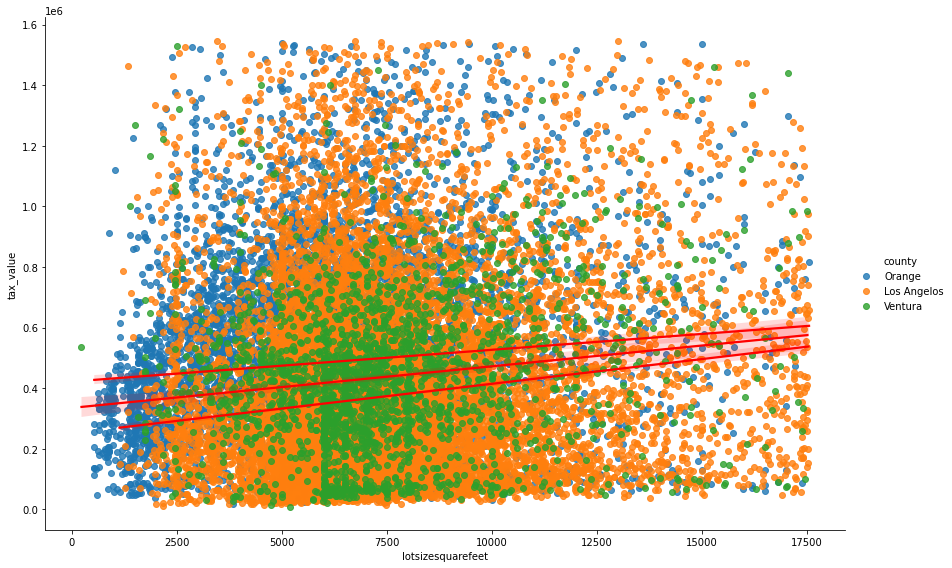

In [27]:
cat_vars = ['bathroomcnt', 'bedroomcnt', 'county', 'fireplacecnt', 'garagecarcnt', 
            'poolcnt', 'yearbuilt']
num_vars = ['sqft', 'lotsizesquarefeet']

for cat in cat_vars:
    plt.figure(figsize=(12,8))
    plt.title(f'Tax value and {cat}')
    sns.boxplot(data=train, y='tax_value', x=cat)
    plt.show()
    
for num in num_vars:
    sns.lmplot(data=train, y='tax_value', x=num, height=8, aspect=12/8, hue='county',line_kws={'color':'red'})
    plt.show()

In [27]:
train.hashottuborspa.value_counts()

0.0    25592
1.0      626
Name: hashottuborspa, dtype: int64

In [15]:
train.fireplacecnt.value_counts()

0.0    22458
1.0     3292
2.0      405
3.0       60
4.0        3
Name: fireplacecnt, dtype: int64

In [33]:
o = df[df.county == 'Orange']
l = df[df.county == 'Los Angeles']
v = df[df.county == 'Ventura']


In [37]:
v.hashottuborspa.value_counts(), v.poolcnt.value_counts()

(0.0    3708
 Name: hashottuborspa, dtype: int64,
 0.0    3113
 1.0     595
 Name: poolcnt, dtype: int64)

## Orange county is the only county with counts for hot tub/spa.  Will need to drop that column for final notebook

In [14]:
train['sqftperroom'] = train.sqft / (train.bedroomcnt + train.bathroomcnt)

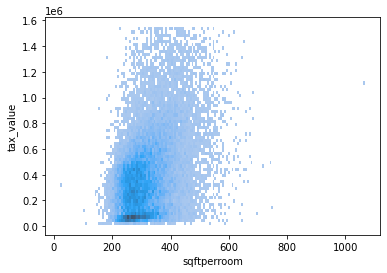

In [17]:
sns.histplot(data=train, y='tax_value', x='sqftperroom')
plt.show()